# Data Analysis

## Numbers for Cash vs Card 

In [21]:
import pandas as pd

# list with all the datasets used
datasets_tranlevel = ['../angelazhang54/frbatl_2012diary_dcpc_2012_public_v3_csv.csv', '../angelazhang54/frbatl_2015diary_dcpc-2015-public-data-csv.csv', 
           '../angelazhang54/frbatl_2016diary_dcpc-2016-public-data-csv.csv', '../angelazhang54/frbatl_2017diary_dcpc_2017_tranlevel-csv.csv',
           '../angelazhang54/dcpc_2018_tranlevel-csv.csv', '../angelazhang54/dcpc_2019_tranlevel_public-csv.csv', 
           '../angelazhang54/dcpc_2020_tranlevel_public_csv.csv', '../angelazhang54/dcpc_2021_tranlevel_public_xls.csv',
           '../angelazhang54/dcpc_2022_tranlevel_public_xls.csv', '../angelazhang54/dcpc_2023_tranlevel_public_xls.csv']

# put all the counts in a big DataFrame to keep track 
df_total_counts = pd.DataFrame(columns=['cash_counts', 'card_counts'])
index = 0

def collect_numerical_data(csv_address):
    # import data
    df = pd.read_csv(csv_address, low_memory=False)

    # extract variables I want to use
    columns_to_extract = ['amnt', 'pi', 'in_person']
    df = df[columns_to_extract]

    # clear all rows that have missing values in payment amount and whether it was an in-person transaction
    df = df.dropna()

    # find entries with in-person payment amounts less than $25 and 
    df = df[(df['amnt'] <= 25.00) & (df['in_person'] == 1)]

    # iterate through all values of payment instrument and count how many payments were made with cash or card
    cash_count = 0
    card_count = 0
    for instrument in df['pi']:
        if instrument == 1.0:
            cash_count += 1
        elif (instrument == 3.0) | (instrument == 4.0) | (instrument == 5.0):
            card_count += 1

    # add to big DataFrame
    global index
    df_total_counts.loc[index] = [cash_count, card_count]
    index += 1


for dataset in datasets_tranlevel: 
    collect_numerical_data(dataset)

# add in years
df_total_counts['year'] = [2012, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

print(df_total_counts)

   cash_counts  card_counts  year
0         4873         2960  2012
1         2366         2201  2015
2         3224         2994  2016
3         2913         2571  2017
4         2745         2559  2018
5         2564         2715  2019
6          807         1147  2020
7         2257         3419  2021
8         2461         4037  2022
9         2579         4771  2023


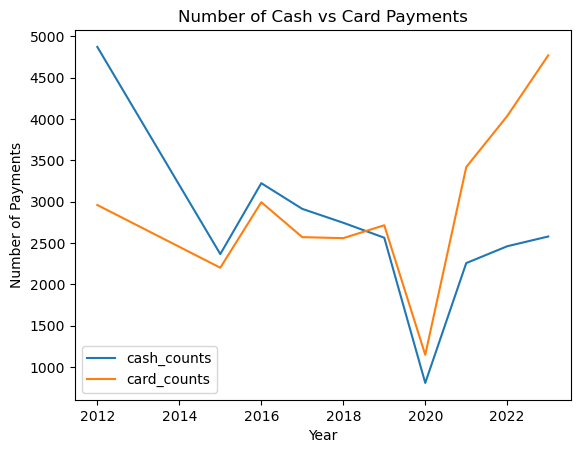

In [22]:
import matplotlib.pyplot as plt

df_total_counts.plot(x = 'year', y = ['cash_counts', 'card_counts'], kind='line')
plt.title('Number of Cash vs Card Payments')
plt.xlabel('Year')
plt.ylabel('Number of Payments')
plt.show()

## Analysis of Reasons

### Personal Preferences and Merchant Acceptance

In [23]:
datasets_tranlevel = ['../angelazhang54/frbatl_2017diary_dcpc_2017_tranlevel-csv.csv',
           '../angelazhang54/dcpc_2018_tranlevel-csv.csv', '../angelazhang54/dcpc_2019_tranlevel_public-csv.csv', 
           '../angelazhang54/dcpc_2020_tranlevel_public_csv.csv']

df_prefs_reasons = pd.DataFrame(columns=['payment type used', 'reason'])
index = 0

def collect_payment_pref(csv_address):
    # import data
    df = pd.read_csv(csv_address, low_memory=False)

    # extract variables I want to use
    columns_to_extract = ['pi', 'in_person', 'paypref_tran']
    df = df[columns_to_extract]

    # clear all rows that have missing values
    df = df.dropna()

    # filter so that for all remaining entries, the payment was made in person
    df = df[(df['in_person'] == 1)]

    # track payment instrument and reason
    global index
    for ind, row in df.iterrows():
        cash = 1
        instrument = row['pi']
        reason = row['paypref_tran']
        if reason == 10.0:
            continue
        if instrument == 1.0:
            cash = 1
        elif (instrument == 3.0) | (instrument == 4.0):
            cash = 0
        df_prefs_reasons.loc[index] = [cash, reason]
        index += 1



# collect values for all datasets
for dataset in datasets_tranlevel: 
    collect_payment_pref(dataset)

#find most common reason for using cash payment
df_prefs_reasons_cash = df_prefs_reasons[(df_prefs_reasons['payment type used'] == 1.0)]
print(df_prefs_reasons_cash)
print(df_prefs_reasons_cash['reason'].mode())

#find most common reason for using card payment
df_prefs_reasons_card = df_prefs_reasons[(df_prefs_reasons['payment type used'] == 0.0)]
print(df_prefs_reasons_card)
print(df_prefs_reasons_card['reason'].mode())


     payment type used  reason
1                  1.0     7.0
3                  1.0     2.0
8                  1.0     2.0
13                 1.0     6.0
14                 1.0     2.0
..                 ...     ...
631                1.0     9.0
632                1.0     9.0
633                1.0     9.0
650                1.0     1.0
651                1.0     1.0

[158 rows x 2 columns]
0    2.0
Name: reason, dtype: float64
     payment type used  reason
0                  0.0     1.0
2                  0.0     5.0
4                  0.0     6.0
5                  0.0     6.0
6                  0.0     2.0
..                 ...     ...
646                0.0     8.0
647                0.0     8.0
648                0.0     8.0
649                0.0     8.0
652                0.0     2.0

[495 rows x 2 columns]
0    1.0
Name: reason, dtype: float64


### Transaction size

In [24]:
from statsmodels.formula.api import ols

datasets_tranlevel = ['../angelazhang54/frbatl_2012diary_dcpc_2012_public_v3_csv.csv', '../angelazhang54/frbatl_2015diary_dcpc-2015-public-data-csv.csv', 
           '../angelazhang54/frbatl_2016diary_dcpc-2016-public-data-csv.csv', '../angelazhang54/frbatl_2017diary_dcpc_2017_tranlevel-csv.csv',
           '../angelazhang54/dcpc_2018_tranlevel-csv.csv', '../angelazhang54/dcpc_2019_tranlevel_public-csv.csv', 
           '../angelazhang54/dcpc_2020_tranlevel_public_csv.csv', '../angelazhang54/dcpc_2021_tranlevel_public_xls.csv',
           '../angelazhang54/dcpc_2022_tranlevel_public_xls.csv', '../angelazhang54/dcpc_2023_tranlevel_public_xls.csv']

# put all the counts in a big DataFrame to keep track 
df_amnts = pd.DataFrame(columns=['card', 'amount'])
index = 0

def amount_data(csv_address):
    # import data
    df = pd.read_csv(csv_address, low_memory=False)

    # extract variables I want to use
    columns_to_extract = ['amnt', 'pi', 'in_person']
    df = df[columns_to_extract]

    # clear all rows that have missing values in payment amount 
    df = df.dropna()

    # find entries with in-person payment 
    df = df[(df['in_person'] == 1)]

    # iterate through all values of payment instrument and count how many payments were made with cash or card
    global index 
    for ind, row in df.iterrows():
        card = 0
        instrument = row['pi']
        amount = row['amnt']
        if instrument == 1.0:
            card = 0
        elif (instrument == 3.0) | (instrument == 4.0):
            card = 1
        df_amnts.loc[index] = [card, amount]
        index += 1


for dataset in datasets_tranlevel: 
    amount_data(dataset)


In [25]:
'''
# run ols model
model = ols('cash ~ amount', data = df_amnts) # create linear model
fit = model.fit() 
fit.summary()
'''

"\n# run ols model\nmodel = ols('cash ~ amount', data = df_amnts) # create linear model\nfit = model.fit() \nfit.summary()\n"

In [26]:
import statsmodels.api as sm

# 'X' can include other variables such as demographics, location, or merchant type
X = df_amnts['amount']  # Add other columns as needed
X = sm.add_constant(X)  # Adds a constant term to the model
y = df_amnts['card']  # 1 for card, 0 for cash 

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary 
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.686376
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   card   No. Observations:                98234
Model:                          Logit   Df Residuals:                    98232
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Nov 2024   Pseudo R-squ.:               0.0004195
Time:                        09:35:34   Log-Likelihood:                -67425.
converged:                       True   LL-Null:                       -67454.
Covariance Type:            nonrobust   LLR p-value:                 5.354e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2378      0.007     36.094      0.000       0.225       0.251
amount        -0.0002    2.6e